## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import rioxarray as rxr
import geopandas as gpd

## Import Files

In [2]:
directory = '../Landsat_Data/DSWE_CRB/'
landsat = [file for file in os.listdir(directory) if (file.startswith("LT05_CU_011009_") or file.startswith("LC08_CU_011009_"))]
print(len(landsat))

2057


## Test Tools for Tile Access

In [3]:
tiff_file = rxr.open_rasterio(directory + landsat[0], masked=True)
tiff_file

<xarray.DataArray (band: 1, y: 5000, x: 5000)>
[25000000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -9.156e+05 -9.155e+05 ... -7.656e+05 -7.656e+05
  * y            (y) float64 1.965e+06 1.965e+06 ... 1.815e+06 1.815e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     dynamic surface water extent: filtered by: percent slope -...

For some reason the x values are sorted to increase in value, whereas the y values are sorted to decrease in value. Due to this, the slicing on the y values must be flipped (ie. y=slice(larger value, smaller value))

In [4]:
tiff_file.rio.crs

CRS.from_wkt('PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.256999999996,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [5]:
tiff_file.rio.bounds()

(-915585.0, 1814805.0, -765585.0, 1964805.0)

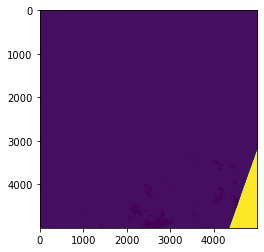

In [6]:
imarray = plt.imread(directory + landsat[0])
plt.imshow(imarray)

In [7]:
np.array(imarray)

array([[  9,   9,   9, ...,   9,   9,   9],
       [  9,   9,   9, ...,   9,   9,   9],
       [  9,   9,   9, ...,   9,   9,   9],
       ...,
       [  9,   9,   9, ..., 255, 255, 255],
       [  9,   9,   9, ..., 255, 255, 255],
       [  9,   9,   9, ..., 255, 255, 255]], dtype=uint8)

## Filter Tiles to Region of Interest

<AxesSubplot:>

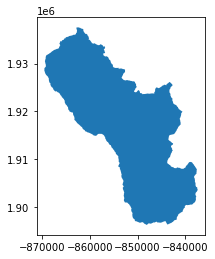

In [8]:
shape = gpd.read_file("../Landsat_Data/DSWE_Williams_Fork_SHPs/StaID09038500.shp")
shape.plot()

In [9]:
print(shape.bounds)

       minx       miny      maxx       maxy
0 -869535.0  1896195.0 -837405.0  1937595.0


In [10]:
tiff_file.x

<xarray.DataArray 'x' (x: 5000)>
array([-915570., -915540., -915510., ..., -765660., -765630., -765600.])
Coordinates:
  * x            (x) float64 -9.156e+05 -9.155e+05 ... -7.656e+05 -7.656e+05
    spatial_ref  int64 0

In [11]:
tiff_file.y

<xarray.DataArray 'y' (y: 5000)>
array([1964790., 1964760., 1964730., ..., 1814880., 1814850., 1814820.])
Coordinates:
  * y            (y) float64 1.965e+06 1.965e+06 ... 1.815e+06 1.815e+06
    spatial_ref  int64 0

For some reason the x values are sorted to increase in value, whereas the y values are sorted to decrease in value. Due to this, the slicing on the y values must be flipped (ie. y=slice(larger value, smaller value))

In [12]:
tiff_file_sliced = tiff_file.sel(x=slice(-869535, -837405), y=slice(1937595, 1896195))
tiff_file_sliced

<xarray.DataArray (band: 1, y: 1380, x: 1071)>
[1477980 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -8.695e+05 -8.695e+05 ... -8.374e+05 -8.374e+05
  * y            (y) float64 1.938e+06 1.938e+06 ... 1.896e+06 1.896e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     dynamic surface water extent: filtered by: percent slope -...

In [13]:
tiff_file_sliced.values

array([[[9., 9., 9., ..., 9., 9., 9.],
        [9., 9., 9., ..., 9., 9., 9.],
        [9., 9., 9., ..., 9., 9., 9.],
        ...,
        [9., 9., 9., ..., 9., 9., 9.],
        [9., 9., 9., ..., 9., 9., 9.],
        [9., 9., 9., ..., 9., 9., 9.]]], dtype=float32)

## Find Clear Tiles in Region of Interest

In [14]:
lst_clear = []
nan_files = []
for file in landsat:
    tiff_file = rxr.open_rasterio(directory + file, masked=True)
    tiff_file_sliced = tiff_file.sel(x=slice(-869535, -837405), y=slice(1937595, 1896195))
    if 9 not in tiff_file_sliced.values:
        lst_clear.append(file)
        if 255 in tiff_file_sliced.values:
            nan_files.append(file)
print(len(lst_clear))
print(len(nan_files))

1181
0


In [15]:
lst_clear.sort()
lst_clear

['LC08_CU_011009_20130417_20190507_C01_V01_INWM.tif',
 'LC08_CU_011009_20130419_20190507_C01_V01_INWM.tif',
 'LC08_CU_011009_20130505_20190507_C01_V01_INWM.tif',
 'LC08_CU_011009_20130519_20190507_C01_V01_INWM.tif',
 'LC08_CU_011009_20130521_20190209_C01_V01_INWM.tif',
 'LC08_CU_011009_20130604_20190507_C01_V01_INWM.tif',
 'LC08_CU_011009_20130606_20190507_C01_V01_INWM.tif',
 'LC08_CU_011009_20130620_20190506_C01_V01_INWM.tif',
 'LC08_CU_011009_20130622_20190209_C01_V01_INWM.tif',
 'LC08_CU_011009_20130706_20190506_C01_V01_INWM.tif',
 'LC08_CU_011009_20130708_20190605_C01_V01_INWM.tif',
 'LC08_CU_011009_20130722_20181209_C01_V01_INWM.tif',
 'LC08_CU_011009_20130724_20190512_C01_V01_INWM.tif',
 'LC08_CU_011009_20130807_20190506_C01_V01_INWM.tif',
 'LC08_CU_011009_20130809_20190506_C01_V01_INWM.tif',
 'LC08_CU_011009_20130823_20181209_C01_V01_INWM.tif',
 'LC08_CU_011009_20130825_20190506_C01_V01_INWM.tif',
 'LC08_CU_011009_20130908_20181209_C01_V01_INWM.tif',
 'LC08_CU_011009_20130910_20

We found 1181 tiles of clear days with no NaN values within our region of interest! This ends up being pretty evenly distributed data (from a quick glance) from 1984-2021. This will work quite nicely!

In [16]:
np.savetxt(
    "../Landsat_Data/Clear_Tiles_Williams_Fork.csv", 
   lst_clear,
   delimiter =", ", 
   fmt ='% s'
)